# **Análise Exploratória dos Dados do ENEM 2019**

Este notebook tem como objetivo realizar uma análise exploratória dos microdados do ENEM 2019. Através desta análise, buscamos compreender melhor os padrões e tendências associados ao desempenho dos estudantes, bem como identificar possíveis correlações entre diferentes variáveis. Além disso, exploramos como fatores como renda, tipo de escola, idade, gênero, entre outros, podem influenciar nas notas dos candidatos.

Ao longo deste documento, investigaremos questões-chave, visualizaremos distribuições de dados e extrair insights valiosos que podem informar políticas educacionais, estratégias de preparação para exames e pesquisas futuras no campo da educação.

## Bibliotecas e Carregamento do Dataset

In [ ]:
# Importando as bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# 'Montar' o Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

# Descompactar o dataset (if it's in .zip format)
!unzip -q "/content/gdrive/MyDrive/DESAFIO_ENEM.zip" -d "/content/dataset/"

Mounted at /content/gdrive


## Análise Inicial dos Dados

In [ ]:
# Carregando o dataset inicial com o delimitador correto
df = pd.read_csv('/content/dataset/DESAFIO_ENEM/DADOS/dado_mg.csv', delimiter=';', low_memory=False)

# Mostrando as primeiras linhas do dataset
df.head()

,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,190001237802,2019,3118601,Contagem,31,MG,22.0,F,1,1,...,B,A,A,B,A,A,C,B,B,B
1,190001237803,2019,3170206,Uberlândia,31,MG,30.0,F,1,2,...,A,A,A,B,A,A,B,A,A,A
2,190001237804,2019,3124104,Esmeraldas,31,MG,27.0,M,1,3,...,A,A,A,B,A,B,C,A,A,A
3,190001237805,2019,3118304,Conselheiro Lafaiete,31,MG,22.0,F,1,1,...,B,A,B,C,B,A,E,A,B,B
4,190001237806,2019,3162922,São Joaquim de Bicas,31,MG,23.0,F,1,4,...,B,A,A,B,B,A,C,A,B,B


### Removendo colunas não essenciais para a Análise

In [ ]:
# Removendo colunas não essenciais
colunas_a_remover = [
    'CO_MUNICIPIO_NASCIMENTO', 'NO_MUNICIPIO_NASCIMENTO',
    'CO_UF_NASCIMENTO', 'SG_UF_NASCIMENTO',
    'CO_ESCOLA', 'CO_MUNICIPIO_ESC', 'NO_MUNICIPIO_ESC',
    'CO_UF_ESC', 'SG_UF_ESC',
    'TP_SIT_FUNC_ESC',
    'CO_PROVA_CN', 'CO_PROVA_CH', 'CO_PROVA_LC', 'CO_PROVA_MT',
    'TX_RESPOSTAS_CN', 'TX_RESPOSTAS_CH', 'TX_RESPOSTAS_LC',
    'TX_RESPOSTAS_MT', 'TX_GABARITO_CN', 'TX_GABARITO_CH',
    'TX_GABARITO_LC', 'TX_GABARITO_MT', 'TP_STATUS_REDACAO'
]

# Removendo o conjunto revisado de colunas não essenciais
df_limpo = df.drop(columns=colunas_a_remover, errors='ignore')

# Para colunas como NU_IDADE onde os valores ausentes são mínimos, você pode remover as linhas
df_limpo.dropna(subset=['NU_IDADE'], inplace=True)

# Para colunas com notas, você pode preencher os valores ausentes com 0
colunas_notas = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']
df_limpo[colunas_notas] = df_limpo[colunas_notas].fillna(0)

# Focando em candidatos que possuem todas as 5 notas válidas
df_limpo = df_limpo[(df_limpo['NU_NOTA_CN'] > 0) &
                    (df_limpo['NU_NOTA_CH'] > 0) &
                    (df_limpo['NU_NOTA_LC'] > 0) &
                    (df_limpo['NU_NOTA_MT'] > 0) &
                    (df_limpo['NU_NOTA_REDACAO'] > 0)]

# Verificando o novo shape do dataframe após a limpeza
print(f"O dataframe após a limpeza possui {df_limpo.shape[0]} linhas e {df_limpo.shape[1]} colunas.")


O dataframe após a limpeza possui 381637 linhas e 113 colunas.


Optamos por simplificar nosso conjunto de dados removendo colunas que não são essenciais para nossa análise. É necessário ressaltar que candidatos que obteram nota 0 em alguma das provas serão removidos.

Estas decisões foram tomadas para tornar o conjunto de dados mais gerenciável e focado em nossos objetivos de análise e modelagem. Ao remover informações redundantes ou não essenciais, podemos conduzir uma análise mais clara e concisa.

## Análise e Tratamento de Valores Nulos

In [ ]:
# Identificar colunas com valores nulos
colunas_nulas = df_limpo.isnull().sum()
colunas_nulas = colunas_nulas[colunas_nulas > 0]

# Calcular a proporção de valores nulos
proporcao_nulos = (colunas_nulas / len(df)) * 100

# Exibir colunas com valores nulos e sua proporção
print("Colunas com Valores Nulos e sua Proporção (%):\n")
print(proporcao_nulos)


Colunas com Valores Nulos e sua Proporção (%):

TP_ENSINO                 32.478906
TP_DEPENDENCIA_ADM_ESC    54.685416
TP_LOCALIZACAO_ESC        54.685416
dtype: float64


Como podemos ver, uma alta proporção de valores nulos se encontra nessa colunas. Devido à natureza dessas features e à grande quantidade, se torna complicado o processo de imputação nesses casos. Optamos por remover as linhas ausentes em cada uma delas.

In [ ]:
# Removendo linhas onde 'TP_ENSINO', 'TP_DEPENDENCIA_ADM_ESC' e 'TP_LOCALIZACAO_ESC' são nulos
df_limpo.dropna(subset=['TP_ENSINO', 'TP_DEPENDENCIA_ADM_ESC', 'TP_LOCALIZACAO_ESC'], inplace=True)
df_limpo = df_limpo[df_limpo['TP_ESCOLA'] != 1]

# Verificar novamente as colunas com valores nulos após a remoção
colunas_nulas = df_limpo.isnull().sum()
colunas_nulas = colunas_nulas[colunas_nulas > 0]

# Calcular a proporção de valores nulos
proporcao_nulos = (colunas_nulas / len(df_limpo)) * 100

# Exibir colunas com valores nulos e sua proporção
print("Colunas com Valores Nulos e sua Proporção (%):\n")
print(proporcao_nulos)


Colunas com Valores Nulos e sua Proporção (%):

Series([], dtype: float64)


In [ ]:
# Exportação do dataset após o tratamento final

df_limpo.to_csv('/content/dataset/DESAFIO_ENEM/DADOS/df.csv', index=False)




---



## Análise Descritiva

In [ ]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df_limpo.describe()

,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,NU_IDADE,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,...,NU_NOTA_LC,NU_NOTA_MT,TP_LINGUA,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q005
count,84931.00,84931.00,84931.00,84931.00,84931.00,84931.00,84931.00,84931.00,84931.00,84931.00,...,84931.00,84931.00,84931.00,84931.00,84931.00,84931.00,84931.00,84931.00,84931.00,84931.00
mean,190003106014.29,2019.00,3136583.44,31.02,17.67,1.00,2.04,1.03,2.00,0.00,...,533.11,554.11,0.34,130.11,135.32,126.04,134.15,109.81,635.43,3.95
std,1360199.60,0.00,51463.14,0.47,1.08,0.21,1.01,0.22,0.00,0.00,...,58.59,115.05,0.47,24.74,39.00,35.99,33.25,58.52,167.50,1.20
min,190001220316.00,2019.00,2202091.00,22.00,11.00,0.00,0.00,0.00,2.00,0.00,...,322.30,359.00,0.00,0.00,40.00,0.00,0.00,0.00,60.00,1.00
25%,190002141985.00,2019.00,3113305.00,31.00,17.00,1.00,1.00,1.00,2.00,0.00,...,499.40,459.90,0.00,120.00,120.00,100.00,120.00,80.00,540.00,3.00
50%,190002832177.00,2019.00,3135100.00,31.00,18.00,1.00,2.00,1.00,2.00,0.00,...,537.60,539.20,0.00,120.00,120.00,120.00,120.00,120.00,620.00,4.00
75%,190004162918.50,2019.00,3152550.50,31.00,18.00,1.00,3.00,1.00,2.00,0.00,...,573.40,637.40,1.00,160.00,160.00,160.00,160.00,160.00,760.00,5.00
max,190006120177.00,2019.00,5300108.00,53.00,56.00,4.00,5.00,4.00,2.00,0.00,...,749.30,985.50,1.00,200.00,200.00,200.00,200.00,200.00,1000.00,20.00


Podemos concluir que:
Contagem de Dados (count):

- Todas as colunas têm a mesma contagem, o que indica que não há valores ausentes nessas colunas após a limpeza dos dados.
Média (mean):

- A idade média (NU_IDADE) dos participantes é de aproximadamente 17,67 anos, o que faz sentido, já que a maioria dos participantes do ENEM são estudantes do ensino médio.
Desvio Padrão (std):

- O desvio padrão das notas (NU_NOTA_*) varia, mas não é extremamente alto, indicando que as notas estão relativamente concentradas em torno da média.
Valores Mínimos e Máximos (min e max):

- Há um participante com 56 anos, o que é atípico para o ENEM, mas não impossível. Pode ser interessante investigar isso mais a fundo.
As notas máximas nas seções individuais do ENEM variam, com a nota máxima em matemática (NU_NOTA_MT) sendo a mais alta. Isso é esperado, já que essa seção tem uma escala de pontuação diferente.
Mediana (50% ou Q2):

- A mediana da idade é 18, o que está alinhado com a expectativa de que a maioria dos participantes está concluindo o ensino médio.
As medianas das notas estão em torno de 500-600, com exceção da redação. Isso nos dá uma boa ideia do desempenho "típico" dos alunos.
1º e 3º Quartil (25% ou Q1 e 75% ou Q3):

- A diferença entre o Q1 e Q3 pode nos dar uma ideia da dispersão dos dados. Por exemplo, em NU_NOTA_MT, o Q1 é 459,90 e o Q3 é 637,40. Isso nos diz que 50% dos alunos têm notas entre esses dois valores em matemática.
Se a diferença entre Q1 e Q3 for grande, isso indica uma maior variabilidade nas notas.

In [ ]:
df_limpo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 534620 entries, 0 to 534626
Columns: 122 entries, NU_INSCRICAO to Q025
dtypes: float64(15), int64(70), object(37)
memory usage: 501.7+ MB


## Análise de Variáveis (Categóricas e Contónuas)

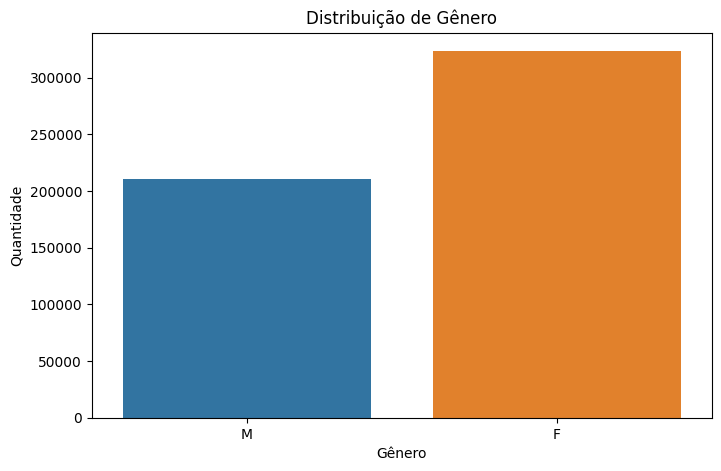

In [ ]:
# Exemplo para a variável "TP_SEXO" (Gênero)
plt.figure(figsize=(8, 5))
sns.countplot(data=df_limpo, x='TP_SEXO', order=['M', 'F'])
plt.title("Distribuição de Gênero")
plt.xlabel("Gênero")
plt.ylabel("Quantidade")
plt.show()


A análise de distribuição de gênero nos permite ver que temos um número consideravelmente superior de participantes mulheres em relação à homens. Isso pode significar que mulheres, em geral, estão mais 'inclinadas' à realizar o exame. Apesar de que essa análise está focada apenas no estado de Minas Gerais, ode ser interessante investigar se essa tendência se mantém em outros estados ou em nível nacional. Se for consistente em todo o país, pode ser um ponto de discussão sobre a inclusão e engajamento de gêneros na educação.

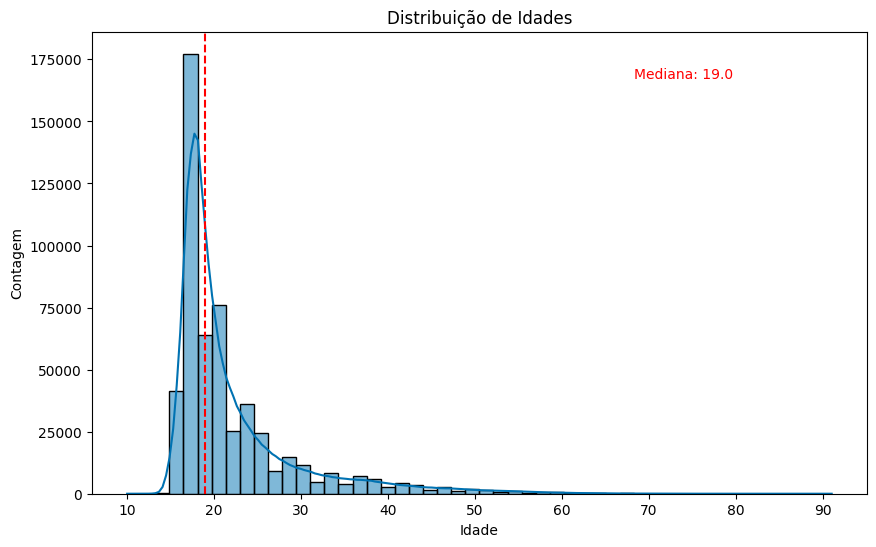

In [ ]:
# Distribuição de Idades dos Candidatos
plt.figure(figsize=(10,6))
sns.histplot(df_limpo['NU_IDADE'], bins=50, kde=True, color="#0072B2")
plt.axvline(df_limpo['NU_IDADE'].median(), color='red', linestyle='--')
plt.text(0.7, 0.9, f"Mediana: {df_limpo['NU_IDADE'].median()}", color='red', transform=plt.gca().transAxes)
plt.title('Distribuição de Idades')
plt.xlabel('Idade')
plt.ylabel('Contagem')
plt.show()

### Detecção de Outliers para Idade


In [ ]:
# Função para detecção de Outliers de acordo com coluna especificada

def filter_outliers(df, column):
    """
    Filtra outliers de uma coluna específica de um DataFrame usando o método IQR.

    Parâmetros:
    - df: DataFrame original
    - column: coluna para a qual os outliers devem ser filtrados

    Retorna:
    - DataFrame filtrado sem os outliers da coluna especificada
    """

    # Calcule o IQR para a coluna
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Defina os limites para os outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Imprime os valores de cada limite
    print(f"Limite inferior para idade: {lower_bound}")
    print(f"Limite superior para idade: {upper_bound}")

    # Filtre o DataFrame
    df_filtrado = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [ ]:
filter_outliers(df_limpo, 'NU_IDADE')

Limite inferior para idade: 10.5
Limite superior para idade: 30.5


- Limite inferior: Estudantes com menos de 18 anos podem não estar fazendo o ENEM com a principal intenção de usar as notas para admissão na faculdade, mas mais como uma prática. Portanto, incluí-los pode distorcer nossa análise, especialmente se quisermos estudar fatores que afetam o desempenho com admissões na faculdade como objetivo final.

- Limite superior: O cálculo que você fez sugere um limite superior de 30,5 anos. Isso parece razoável, pois nos permite focar na principal demografia dos participantes do exame, eliminando valores extremos que podem não ser tão representativos da população geral.

### Filtragem de Dados baseada na Idade

In [ ]:
df_filtrado = df_limpo[(df_limpo['NU_IDADE'] >= 18) & (df_limpo['NU_IDADE'] <= 30)]

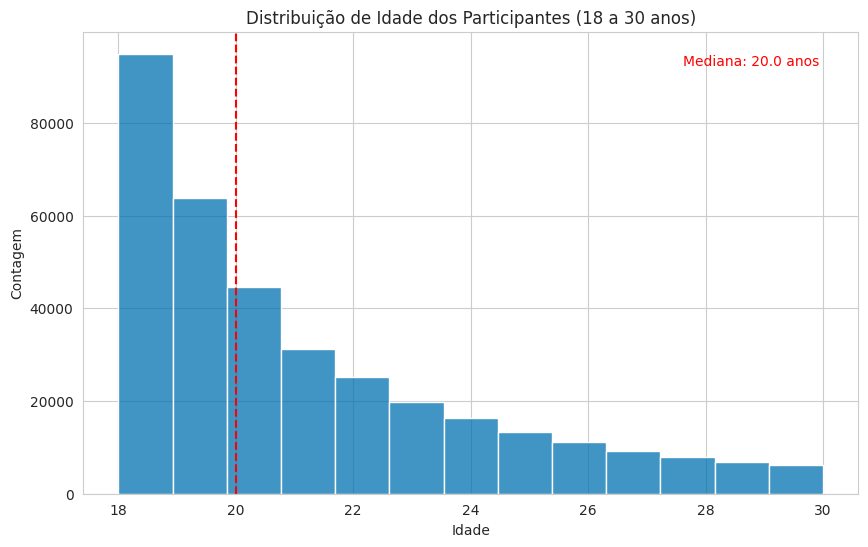

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(df_filtrado['NU_IDADE'], kde=False, bins=13, color="#0072B2")  # Cor escolhida da paleta de cores para daltônicos

# Adicionando uma linha vertical para a mediana
mediana = df_filtrado['NU_IDADE'].median()
plt.axvline(mediana, color='red', linestyle='--')

# Colocando a descrição da mediana no topo à direita
plt.text(0.95, 0.95, f'Mediana: {mediana} anos', color='red', ha='right', va='top', transform=ax.transAxes)

plt.title('Distribuição de Idade dos Participantes (18 a 30 anos)')
plt.xlabel('Idade')
plt.ylabel('Contagem')
plt.show()


Como decidimos trabalhar com esse range específico de Idade, é imprescindível que façamos a exclusão das linhas onde as idades estejam fora dos limites impostos.

In [ ]:
# Excluindo as linhas onde a idade do candidato é menor que 18 ou maior que 30
df_limpo = df_limpo.drop(df_limpo[(df_limpo['NU_IDADE'] < 18) | (df_limpo['NU_IDADE'] > 30)].index)


### Distribuição das Notas dos Candidatos

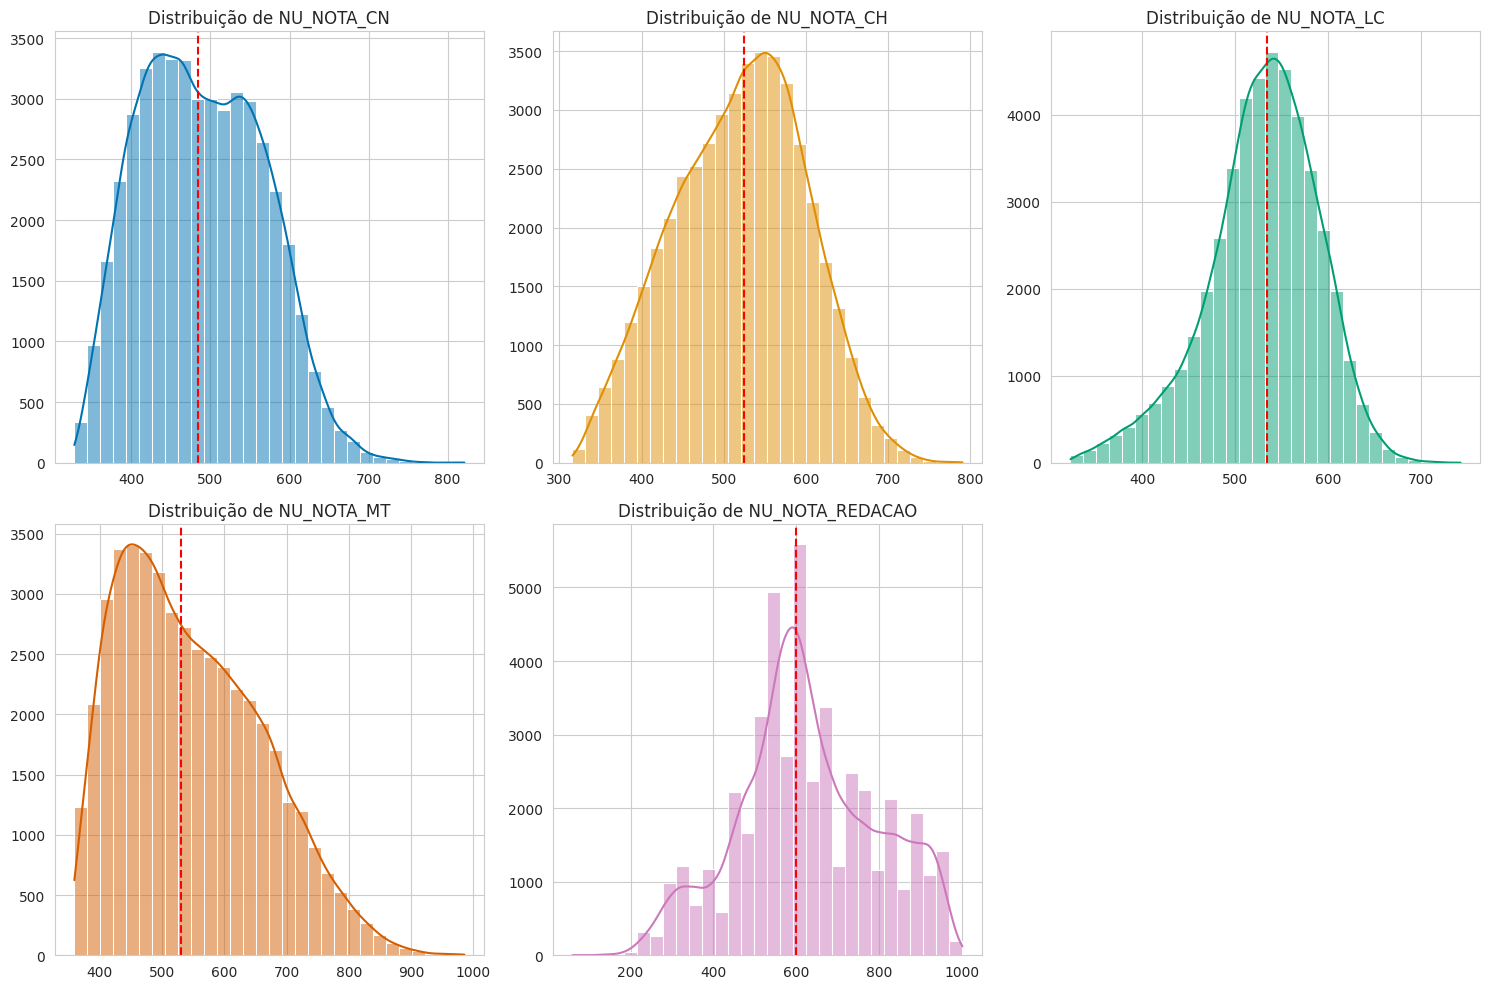

In [ ]:
# Configurando estilo e paleta de cores
sns.set_style("whitegrid")
colors = sns.color_palette("colorblind")

# Lista de colunas das notas
notas = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']

# Inicializando a figura
plt.figure(figsize=(15, 10))

# Loop para plotar as distribuições das notas
for i, col in enumerate(notas, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df_limpo[col], kde=True, color=colors[i-1], bins=30)
    plt.axvline(df_limpo[col].median(), color='red', linestyle='--')
    plt.title(f'Distribuição de {col}')
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.show()

Há um pico pronunciado próximo ao valor de zero, indicando que uma quantidade significativa de candidatos obteve notas muito baixas ou zero em determinadas provas. Vamos realizar uma outra abordagem visual para podermos tirar melhores insights sobre.

In [ ]:
# Lista de colunas das notas
notas = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']

# Filtra o dataframe
df_limpo = df_limpo[df_limpo[notas].apply(lambda x: all(x > 0), axis=1)]


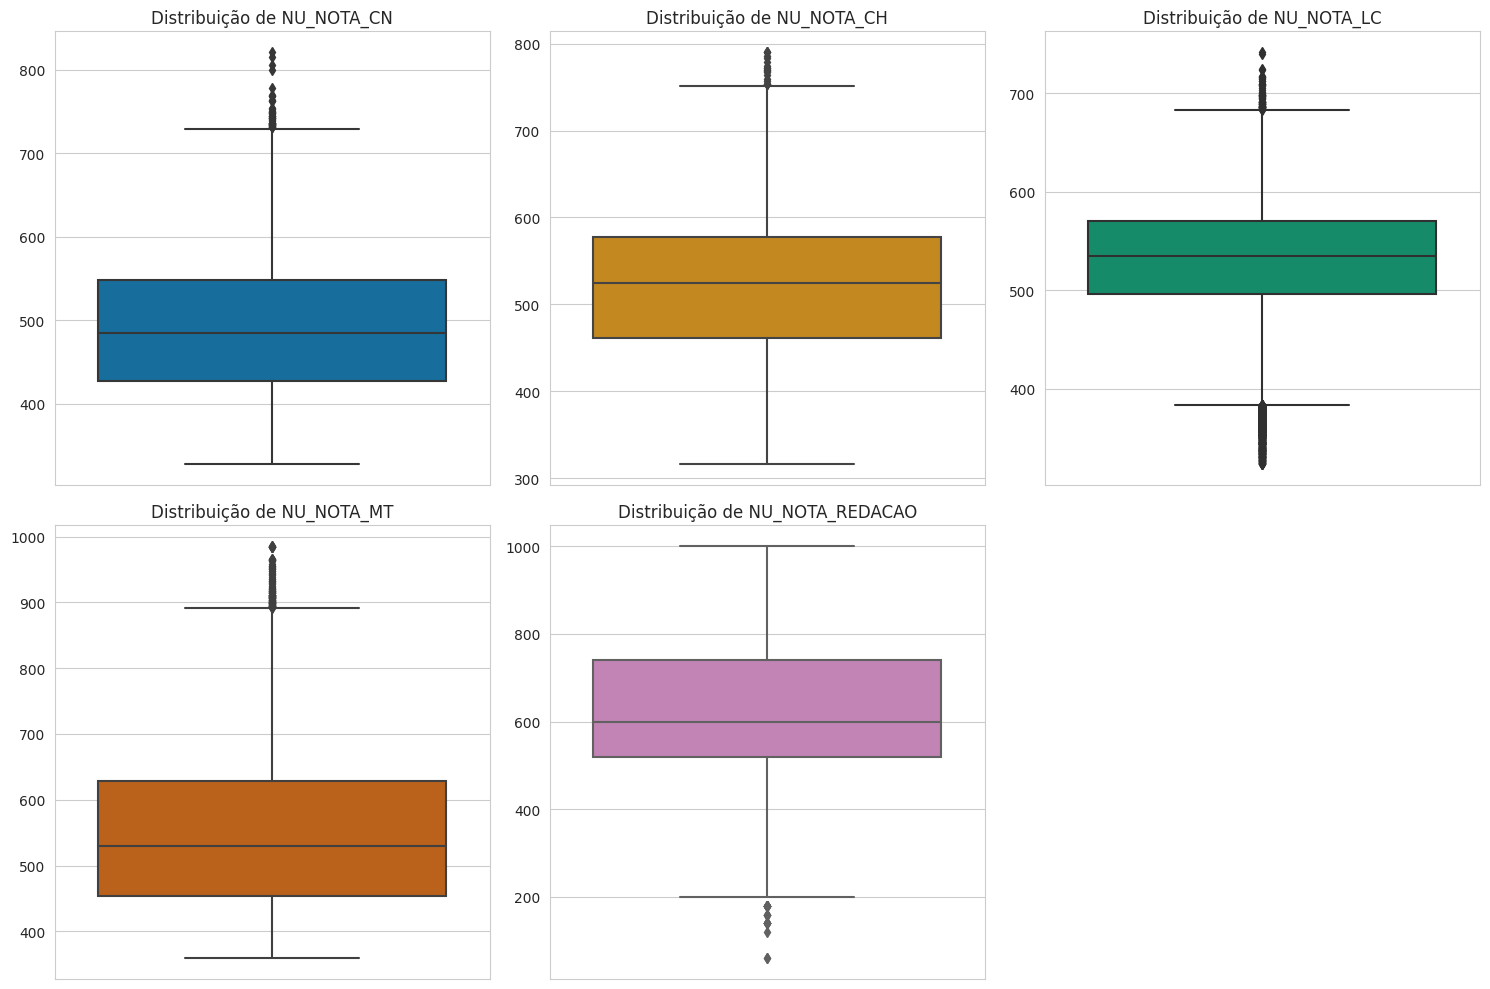

In [ ]:
# Configurando estilo e paleta de cores
sns.set_style("whitegrid")
colors = sns.color_palette("colorblind")  # Paleta de cores que é amigável para daltonismo

# Lista de colunas das notas
notas = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']

# Inicializando a figura
plt.figure(figsize=(15, 10))

# Loop para plotar os boxplots das notas
for i, col in enumerate(notas, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df_limpo[col], color=colors[i-1])
    plt.title(f'Distribuição de {col}')
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.show()


In [ ]:
print(df_limpo[notas].max())


NU_NOTA_CN         821.10
NU_NOTA_CH         790.60
NU_NOTA_LC         741.90
NU_NOTA_MT         985.50
NU_NOTA_REDACAO   1000.00
dtype: float64


O gráfico representa a distribuição das notas dos candidatos e destaca a concentração de notas em torno de valores médios, com exceção do pico significativo perto de zero. Isso sugere que, enquanto a maioria dos candidatos tem um desempenho médio, há uma proporção significativa que não se saiu bem ou possivelmente não compareceu ao exame. Além disso, apenas uma pequena fração de candidatos alcançou notas muito altas. Isso reforça a ideia de que o ENEM é um exame desafiador e que obter uma pontuação alta é uma conquista significativa.




---



## Relações entre Variáveis



### Relação entre Idade e Notas
Vamos começar explorando como a idade se relaciona com as notas.

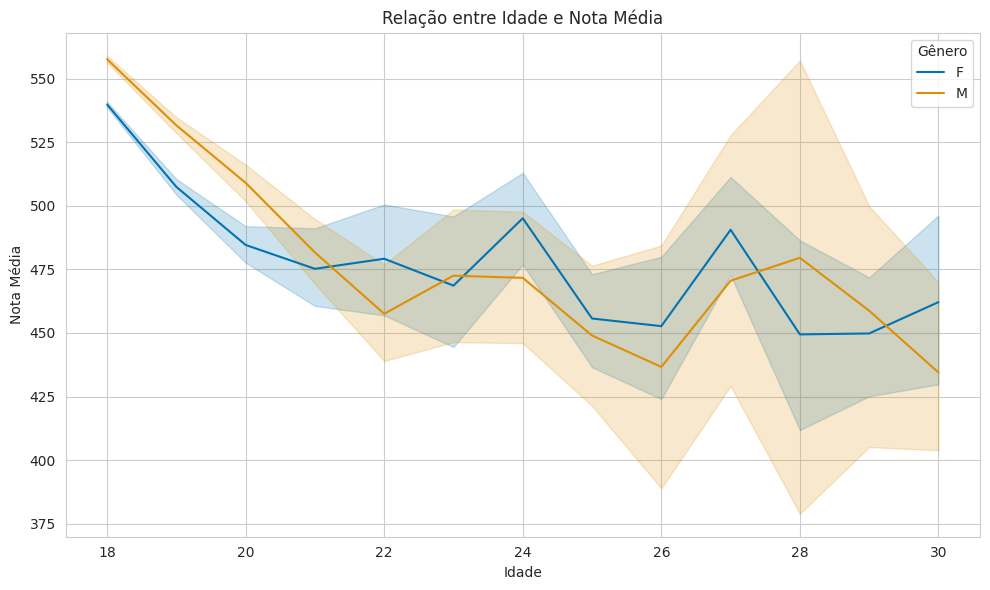

In [ ]:
# Configurando o estilo
sns.set_style("whitegrid")

# Calculando a média das notas
df_limpo['NOTA_MEDIA'] = df_limpo[notas].mean(axis=1)

# Plotando a relação entre idade e nota média
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_limpo, x="NU_IDADE", y="NOTA_MEDIA", hue="TP_SEXO", palette="colorblind")
plt.title('Relação entre Idade e Nota Média')
plt.xlabel('Idade')
plt.ylabel('Nota Média')
plt.legend(title='Gênero')
plt.tight_layout()
plt.show()



Existe uma tendência geral de queda nas notas médias à medida que a idade aumenta. Candidatos mais jovens, em média, tendem a ter desempenho superior em relação aos candidatos mais velhos.
Nota-se também que, à partir da idade aproximada de 22 anos, o desempenho das mulheres é superior ao dos homens, mantendo-se assim até os 27 anos. No entanto, essa diferença dimunui com o aumento da idade.

### Relação entre Tipo de Escola e Notas
Outra relação interessante a ser explorada é entre o tipo de escola (pública ou privada) e as notas.

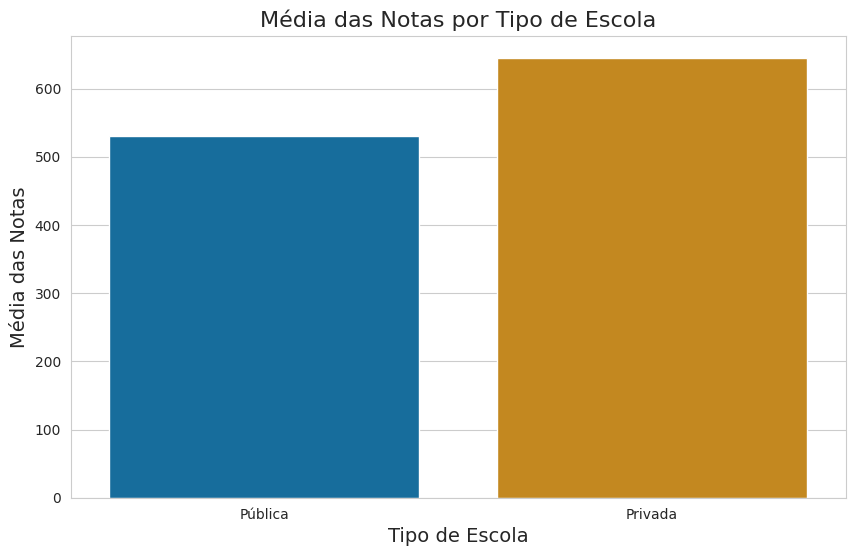

In [ ]:
df_limpo['MEDIA_NOTAS'] = df_limpo[notas].mean(axis=1)

# Mapeamento para os tipos de escola
mapa_escola = {
    1: 'Não Respondeu',
    2: 'Pública',
    3: 'Privada'
}

# Filtrando os dados apenas para os tipos de escola desejados (Pública e Privada)
df_grafico = df_limpo[df_limpo['TP_ESCOLA'].isin([2, 3])]

# Plotando o gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(data=df_grafico, x='TP_ESCOLA', y='MEDIA_NOTAS', palette="colorblind", estimator=np.mean, errorbar=None)
plt.title('Média das Notas por Tipo de Escola', fontsize=16)
plt.xlabel('Tipo de Escola', fontsize=14)
plt.ylabel('Média das Notas', fontsize=14)
plt.xticks(ticks=[0, 1], labels=['Pública', 'Privada'])
plt.show()



O gráfico sugere que, em média, os alunos de escolas privadas tendem a ter um desempenho melhor no ENEM do que os alunos de escolas públicas. No entanto, isso não significa que todos os alunos de escolas privadas se saiam melhor, ou que os alunos de escolas públicas não possam se destacar. É uma indicação das diferenças gerais no desempenho acadêmico entre esses grupos.

### Desempenho por Gênero

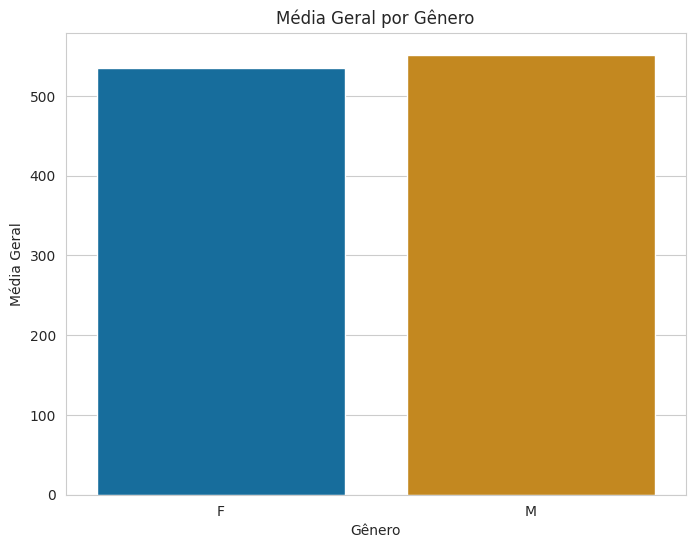

In [ ]:
# Calcula a média geral de notas para cada estudante
df_limpo['MEDIA_GERAL'] = df_limpo[['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']].mean(axis=1)

# Calcula as médias da nota geral por gênero
media_geral_por_genero = df_limpo.groupby('TP_SEXO')['MEDIA_GERAL'].mean()

# Plotagem
plt.figure(figsize=(8, 6))
sns.barplot(x=media_geral_por_genero.index, y=media_geral_por_genero, palette="colorblind")
plt.title('Média Geral por Gênero')
plt.ylabel('Média Geral')
plt.xlabel('Gênero')
plt.show()


O desempenho médio dos homens é levemente superior ao das mulheres. É essencial notar que ambos os gêneros mostraram fortes capacidades acadêmicas, como evidenciado pelas suas pontuações. É importante abordar essa observação com cautela e evitar generalizações amplas, uma vez que múltiplos fatores, incluindo preparação, acesso a recursos e áreas de estudo focadas, podem influenciar os resultados

### Nível de Escolaridade dos Pais vs Média de Notas


A legenda para os códigos referente às colunas de escolaridade do pai e da mãe (Q001 e Q002) é a seguinte:

- A: Nunca estudou.
- B: Não completou a 4ª série/5º ano do Ensino Fundamental.
- C: Completou a 4ª série/5º ano, mas não completou a 8ª série/9º ano do Ensino Fundamental.
- D: Completou a 8ª série/9º ano do Ensino Fundamental, mas não completou o Ensino Médio.
- E: Completou o Ensino Médio, mas não completou a Faculdade.
- F: Completou a Faculdade, mas não completou a Pós-graduação.
- G: Completou a Pós-graduação.
- H: Não sei.

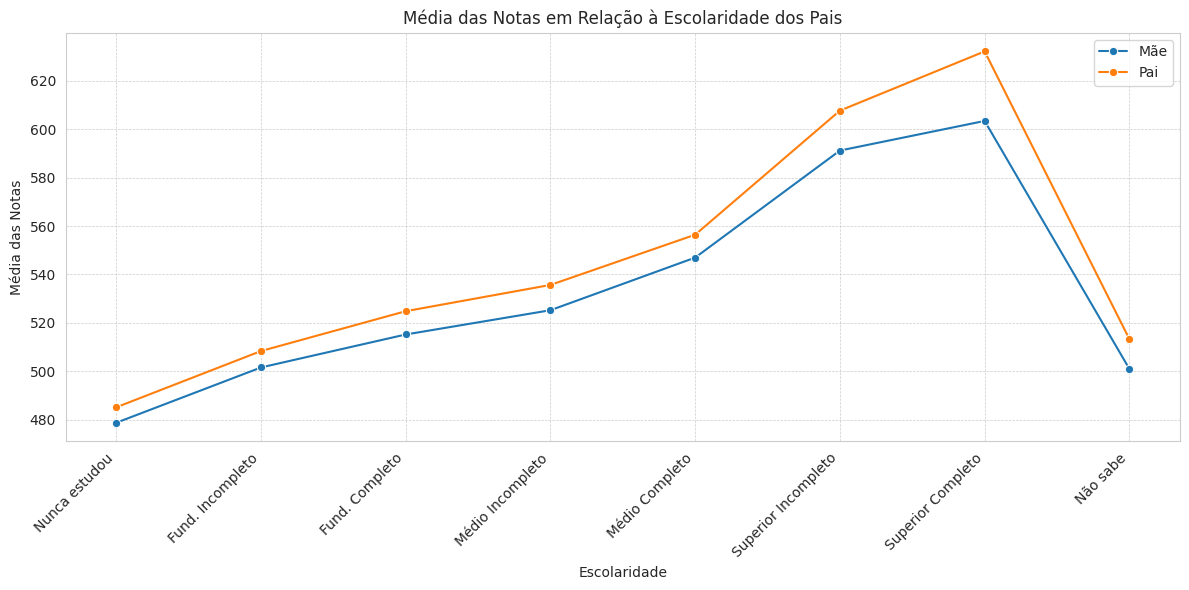

In [ ]:
# Mapeando os códigos de escolaridade
mapeamento_escolaridade = {
    'A': 'Nunca estudou',
    'B': 'Fund. Incompleto',
    'C': 'Fund. Completo',
    'D': 'Médio Incompleto',
    'E': 'Médio Completo',
    'F': 'Superior Incompleto',
    'G': 'Superior Completo',
    'H': 'Não sabe'
}

# Criando um DataFrame com a média das notas para cada nível de escolaridade da mãe
media_mae = df_limpo.groupby('Q002')['MEDIA_NOTAS'].mean().reset_index()
media_mae['Q002'] = media_mae['Q002'].map(mapeamento_escolaridade)

# Criando um DataFrame com a média das notas para cada nível de escolaridade do pai
media_pai = df_limpo.groupby('Q001')['MEDIA_NOTAS'].mean().reset_index()
media_pai['Q001'] = media_pai['Q001'].map(mapeamento_escolaridade)

# Plotando o gráfico de linhas
plt.figure(figsize=(12, 6))
sns.lineplot(x='Q002', y='MEDIA_NOTAS', data=media_mae, marker='o', label='Mãe')
sns.lineplot(x='Q001', y='MEDIA_NOTAS', data=media_pai, marker='o', label='Pai')
plt.title('Média das Notas em Relação à Escolaridade dos Pais')
plt.xlabel('Escolaridade')
plt.ylabel('Média das Notas')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


Podemos perceber que quanto maior o nível de instrução, tanto do pai quanto da mãe, melhor é o desempenho do aluno. Nota-se também que a escolaridade do pai influencia de forma significante na pontuação, ao mesmo tempo que temos um comportamento semelhante entre ambos.

### Renda vs Notas


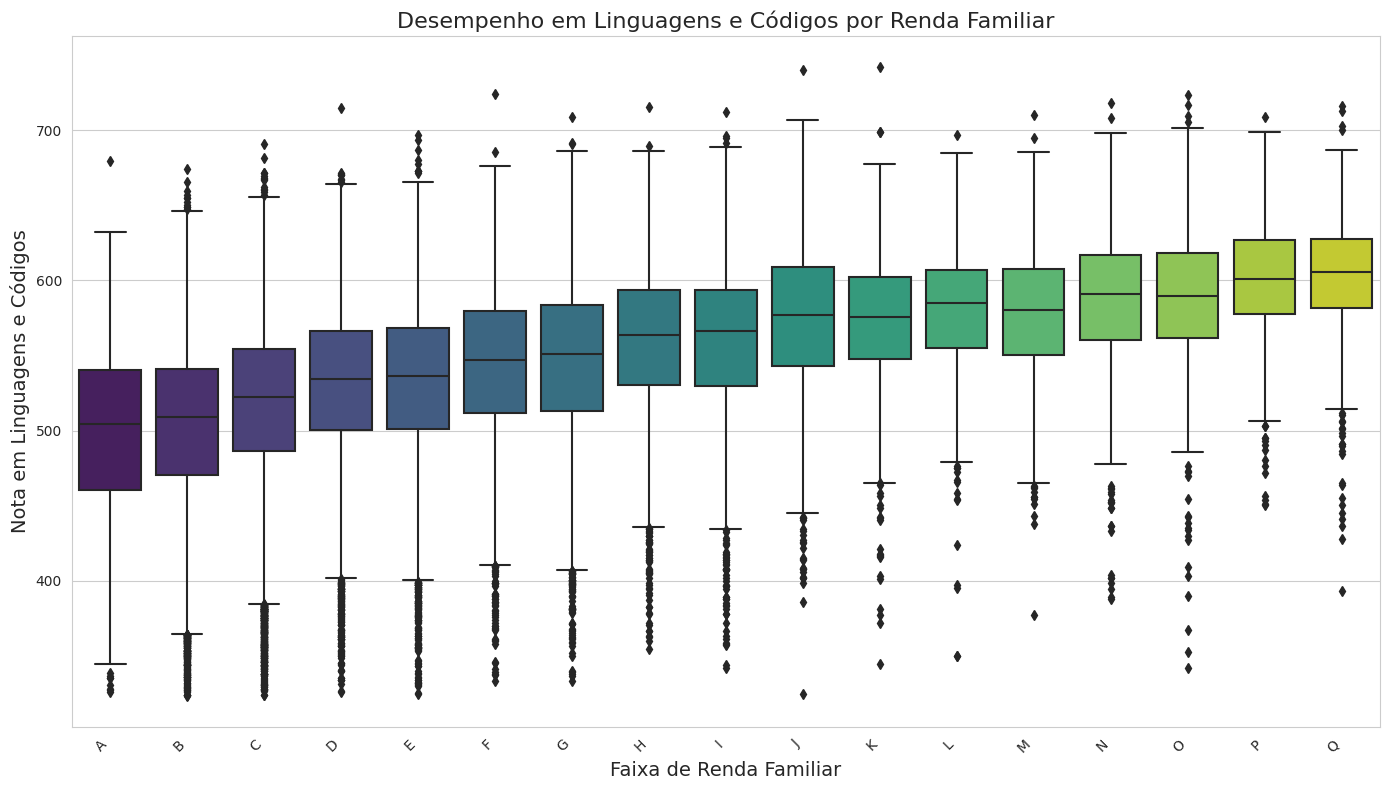

In [ ]:
# Configurando estilo e paleta de cores
sns.set_style("whitegrid")
colors = sns.color_palette("colorblind")  # Paleta de cores para daltonismo

# Mapeamento entre as categorias e suas descrições
mapeamento_renda = {
    'A': "Nenhuma renda",
    'B': "Até R$ 998,00",
    'C': "De R$ 998,01 até R$ 1.497,00",
    'D': "De R$ 1.497,01 até R$ 1.996,00",
    'E': "De R$ 1.996,01 até R$ 2.495,00",
    'F': "De R$ 2.495,01 até R$ 2.994,00",
    'G': "De R$ 2.994,01 até R$ 3.992,00",
    'H': "De R$ 3.992,01 até R$ 4.990,00",
    'I': "De R$ 4.990,01 até R$ 5.988,00",
    'J': "De R$ 5.988,01 até R$ 6.986,00",
    'K': "De R$ 6.986,01 até R$ 7.984,00",
    'L': "De R$ 7.984,01 até R$ 8.982,00",
    'M': "De R$ 8.982,01 até R$ 9.980,00",
    'N': "De R$ 9.980,01 até R$ 11.976,00",
    'O': "De R$ 11.976,01 até R$ 14.970,00",
    'P': "De R$ 14.970,01 até R$ 19.960,00",
    'Q': "Mais de R$ 19.960,00"
}

# Categorias presentes em df_filtrado
categorias_presentes = sorted(df_filtrado['Q006'].unique())

# Ordenação usando o mapeamento
ordem_categorias = [mapeamento_renda[categoria] for categoria in categorias_presentes]

# Plotando o gráfico
plt.figure(figsize=(14, 8))
sns.boxplot(x="Q006", y="NU_NOTA_LC", data=df_limpo, order=mapeamento_renda, palette="viridis")
plt.title("Desempenho em Linguagens e Códigos por Renda Familiar", fontsize=16)
plt.xlabel("Faixa de Renda Familiar", fontsize=14)
plt.ylabel("Nota em Linguagens e Códigos", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Para essa análise, optamos por utiliza a nota de 'Linguagens e Código'. O motivo é que sua distribuição (conforme gráfico acima de Distribuiçao de Notas) é considerada normal/gaussiana. Consequentemente, a maioria dos valores está centrada em torno da média, com dispersão de valores feita igualmente, facilitando a visualização.
Há uma tendência clara de que, à medida que a renda aumenta, a nota dos candidatos também tende a aumentar. Isso é um reflexo das desigualdades sociais presentes na socidade. Famílias com maiores rendas podem ter mais recursos para investir na educação de seus filhos.

### Raça vs Notas
Por último, vamos visualizar a relação entre a declaração de cor/raça e as notas:

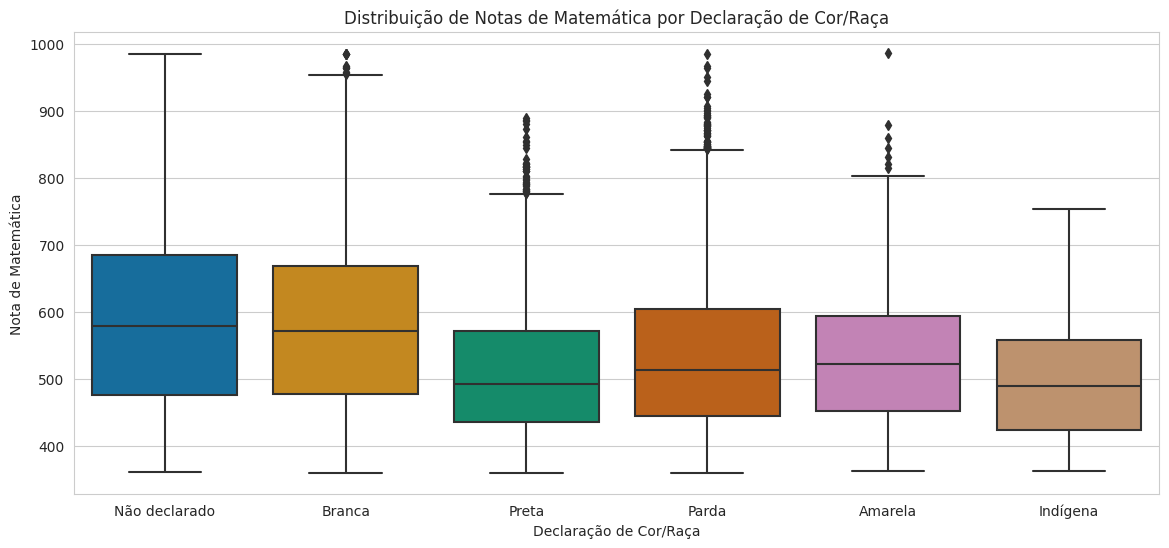

In [ ]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_limpo, x='TP_COR_RACA', y='NU_NOTA_MT', palette="colorblind")
plt.title('Distribuição de Notas de Matemática por Declaração de Cor/Raça')
plt.xlabel('Declaração de Cor/Raça')
plt.ylabel('Nota de Matemática')
plt.xticks([0, 1, 2, 3, 4, 5], ['Não declarado', 'Branca', 'Preta', 'Parda', 'Amarela', 'Indígena'])
plt.show()


O desempenho dos estudantes, quando avaliado com base na raça/cor, mostra que há uma distribuição semelhante de notas entre as categorias. Isso sugere que a raça/cor, por si só, não é um determinante dominante no desempenho acadêmico dos estudantes neste conjunto de dados. No entanto, é importante lembrar que o desempenho acadêmico é influenciado por uma infinidade de fatores, e a raça/cor pode interagir com outros fatores de maneiras complexas. Portanto, embora seja útil observar as tendências neste gráfico, é crucial considerar um contexto mais amplo e outros fatores potencialmente relevantes ao interpretar os resultados.

## Correlações entre as Notas de cada Matéria


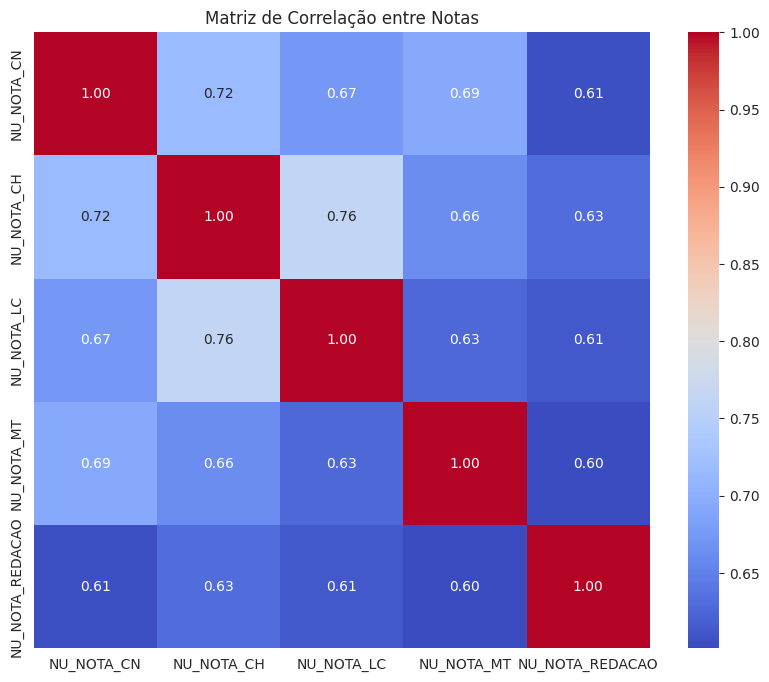

In [ ]:
# Selecionando apenas as colunas de notas para a correlação
colunas_notas = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']

# Calculando a matriz de correlação
corr = df_limpo[colunas_notas].corr()

# Plotando a matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", cbar=True, square=True, fmt=".2f")
plt.title('Matriz de Correlação entre Notas')
plt.show()


- Em geral, os estudantes têm um desempenho consistente em todas as provas. Se eles se saem bem em uma área, é provável que se saiam bem em outras áreas também.
- Percebe-se que as provas de Ciências Humanas e Linguagens e Códigos parecem avaliar habilidades que são mais estreitamente relacionadas entre si do que com outras áreas.
- Embora haja alguma correlação entre o desempenho na redação e em outras provas, a redação avalia um conjunto de habilidades que é, em certa medida, distinto das habilidades avaliadas nas provas objetivas.



---



## Conclusão

- **Principais Descobertas**:
  - A maior proporção de candidatos tem entre 17 e 19 anos.
  - Há mais mulheres que homens participando do ENEM.
  - A renda familiar tem influência nas notas, com candidatos de maior renda tendendo a ter desempenho melhor.
  - Estudantes que frequentam escolas privadas têm, em média, desempenho superior aos de escolas públicas.
  - Há uma correlação positiva entre as notas das diferentes seções do ENEM.

- **Variáveis Mais Importantes**:
  - Renda familiar (`Q006`).
  - Tipo de escola (`TP_ESCOLA`).
  - Notas das diferentes seções, especialmente quando consideradas em conjunto.

- **Relações e Padrões Notáveis**:
  - Há um padrão claro de aumento de notas com o aumento da renda familiar.
  - Há uma tendência clara de decréscimo nas notas médias à medida que a idade aumenta, tanto para homens quanto para mulheres.
  - Estudantes de escolas privadas tendem a ter desempenho superior em comparação aos de escolas públicas e federais.
  - O desempenho nas provas é geralmente consistente; ou seja, quem vai bem em uma prova tende a ir bem nas outras.

- **Próximas Etapas**:
  - Investigar mais profundamente os fatores que influenciam o desempenho dos estudantes de escolas públicas vs. privadas.
  - Analisar a influência de outros fatores sociodemográficos, como localização geográfica, no desempenho dos candidatos.
  - Considerar uma análise temporal, se os dados de anos anteriores estiverem disponíveis, para entender as tendências ao longo do tempo.
